# Load libraries 

In [7]:
#load libraries 
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np, math, pylab
#import ROOT
#from ROOT import TFile

import root_pandas
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

from scipy.optimize import curve_fit


# Load tuple files
The following will automatically download the files from https://userweb.jlab.org/~spaul/sidis_tuple_examples, if they are not already downloaded.  

In [70]:
import urllib.request, os

for filename in "example_mc_large.root",:
    if not (filename in os.listdir(".")):
        url = 'https://userweb.jlab.org/~spaul/sidis_tuples_examples/' +filename
        urllib.request.urlretrieve(url, filename)
        print("downloaded file from " + url)
    else:
        print("found file: " + filename + ",\t no need to re-download")
print("done downloading files")

found file: example_mc_large.root,	 no need to re-download
done downloading files


Now load the tuples from the files.

In [51]:
#electrons: events with at least one electron which passes DIS event selection cuts
#hadrons: events with at least one electron (passing cuts above) and at least one charged hadron
#dihadrons: events with at least one electron and two charged hadrons, one of which is a "leading" pion, (ie, z>0.5)


#same for Monte-Carlo simulations
mc_electrons = root_pandas.read_root("../example_mc.root", "electrons")
mc_hadrons = root_pandas.read_root("../example_mc.root", "hadrons")
mc_dihadrons = root_pandas.read_root("../example_mc.root", "dihadrons")

In [64]:
#apply cuts in order to match the event selection used by Orlando
mc_hadrons = mc_hadrons.query("h_p>1.25 and h_p<5 and h_th>3.14159/180*5 and h_th<3.14159/180*35 and y<0.8")

In [65]:
#print the number of entries in each tuple
print("mc electrons\tlength =", len(mc_electrons))
print("mc hadrons\tlength =", len(mc_hadrons))
print("mc dihadrons\tlength =", len(mc_dihadrons))

mc electrons	length = 2180800
mc hadrons	length = 213247
mc dihadrons	length = 10216


In [66]:
#print the list of variables in each tuple (these are the same for data and monte-carlo)
for df, name in (data_electrons,"electrons"), (data_hadrons,"hadrons"), (data_dihadrons,"dihadrons"):
    print(name + ":")
    print(df.columns)
    print("\n")


electrons:
Index(['E', 'helicity', 'e_p', 'e_th', 'e_ph', 'nelectrons', 'nu', 'Q2', 'x',
       'y', 'W', 'e_DC1x', 'e_DC2x', 'e_DC3x', 'e_DC1y', 'e_DC2y', 'e_DC3y',
       'e_PCALx', 'e_PCALy', 'e_ecalfrac', 'e_pcal', 'e_vz', 'npip', 'npim',
       'npp', 'npm', 'nKp', 'nKm', 'nh', 'z_tot'],
      dtype='object')


hadrons:
Index(['nelectrons', 'E', 'helicity', 'e_p', 'e_th', 'e_ph', 'nu', 'Q2', 'x',
       'y', 'W', 'h_chi2pid', 'h_pid', 'h_p', 'h_th', 'h_ph', 'h_DC1x',
       'h_DC1y', 'h_DC2x', 'h_DC2y', 'h_DC3x', 'h_DC3y', 'dvz', 'z', 'h_cm_p',
       'h_cm_th', 'h_cm_ph', 'h_cm_eta', 'h_cm_pt', 'h_eta', 'dtime',
       'dtime_corr'],
      dtype='object')


dihadrons:
Index(['E', 'helicity', 'e_p', 'e_th', 'e_ph', 'nu', 'Q2', 'x', 'y', 'W',
       'h1_chi2pid', 'h2_chi2pid', 'h1_pid', 'h2_pid', 'h1_p', 'h2_p', 'h1_th',
       'h2_th', 'h1_ph', 'h2_ph', 'h1_z', 'h2_z', 'h1_eta', 'h2_eta',
       'h1_cm_p', 'h2_cm_p', 'h1_cm_th', 'h2_cm_th', 'h1_cm_ph', 'h2_cm_ph',
       'h1_cm_et

In [67]:
def binspace(df, query, min, max, nbins):
    ls = np.linspace(min,max,nbins)
    return [df.query("%s> %s and %s < %s" %(query, mn, query, mx)) for mn,mx in zip(ls[:-1],ls[1:])]

def binomialError(num,denom):
    #return num/denom*np.sqrt(1/min(1,num)+1/min(1,denom))
    if denom == 0:
        return 1
    return 1/denom**(3/2)*np.sqrt(num*(denom-num))
    
def getmeanstd(df, query):
    a = df.eval(query)
    x0, sigma = np.mean(a), np.std(a)
    nbins = 50
    bins = binspace(df,query, x0-5*sigma, x0+5*sigma, nbins)
    x = np.linspace(x0-5*sigma, x0+5*sigma, nbins-1)
    x += (x[1]-x[0])/2
    y = [len(bin) for bin in bins]
    del bins
    def gaus(x,a,x0,sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))
    
    popt,pcov = curve_fit(gaus,x,y,p0=[1,x0,sigma])

    return popt[1],abs(popt[2])

# Plots

Text(0.5, 0, '$\\theta$ (deg)')

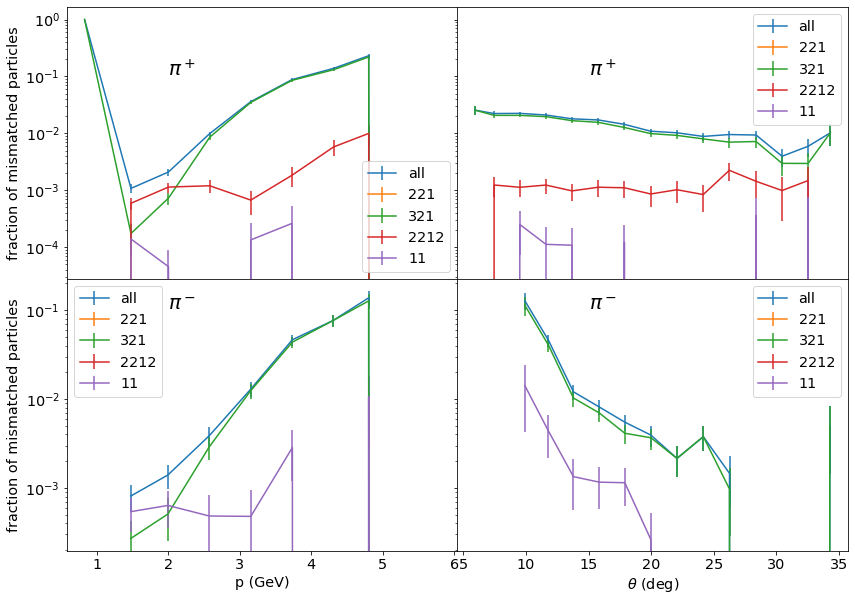

In [68]:
fig, axs = plt.subplots(2,2,figsize=(14,10),sharex='col',sharey='row')
fig.subplots_adjust(wspace=0, hspace=0)
for i,(df,name) in enumerate(zip([mc_hadrons.query("h_p > 0 and h_truth_p > 0 and h_pid==211"),
                      mc_hadrons.query("h_p > 0 and h_truth_p > 0 and h_pid==-211")],
                              "$\\pi^+$ $\\pi^-$".split())):
    for j,(xvar,xrange) in enumerate([("h_truth_p", (0,11)),("h_truth_th*180/3.14159", (0,40))]):
        pids = [221, 321, 2212, 11]
        for selection,name in zip(["True"] +["abs(h_truth_pid) == %s" % pid for pid in pids],
                                 ["all"]+pids):
            bins = binspace(df, xvar, *xrange, 20)
            x=[]
            y = []
            dy = []
            for bin in bins:
                num = len(bin.query("h_pid != h_truth_pid and "+ selection))
                denom = len(bin)
                if(denom != 0):
                    x.append(np.mean(bin.eval(xvar)))
                    y.append(num/denom)
                    dy.append(binomialError(num,denom))
            axs[i][j].errorbar(x,y,dy,label=name)
            plt.sca(axs[i][j])
            plt.yscale("log")
        axs[i][j].legend()
axs[0][0].set_ylabel("fraction of mismatched particles")
axs[1][0].set_ylabel("fraction of mismatched particles")
axs[0][0].text(2, 0.1,"$\\pi^+$",size=20)
axs[0][1].text(15, 0.1, "$\\pi^+$",size=20)
axs[1][0].text(2, 0.1,"$\\pi^-$",size=20)
axs[1][1].text(15, 0.1,"$\\pi^-$",size=20)
axs[1][0].set_xlabel("p (GeV)")
axs[1][1].set_xlabel("$\\theta$ (deg)")